In [2]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

## 4x4 Network

Using synthetic dataset

In [46]:
import numpy as np

# Parameters
num_matrices = 5000
matrix_size = (4, 4)

# Generate matrices filled with ones
matrices = np.ones((num_matrices, *matrix_size))

# Create a sine wave function for scaling
# Let's scale the matrices by the sine of indices (0, 1, ..., num_matrices-1)
scaling_factors = np.abs(np.sin(np.linspace(0, 5 * np.pi, num_matrices)))

# Scale each matrix by its corresponding sine value
scaled_matrices = matrices * scaling_factors[:, np.newaxis, np.newaxis]

[np.fill_diagonal(scaled_matrices[i, :, :], 0) for i in range(num_matrices)]

# Check the shape of the resulting array
print(scaled_matrices.shape)  # Should be (5000, 4, 4)


(5000, 4, 4)


In [47]:
scaled_matrices[500, :, :]

array([[0.        , 0.99999995, 0.99999995, 0.99999995],
       [0.99999995, 0.        , 0.99999995, 0.99999995],
       [0.99999995, 0.99999995, 0.        , 0.99999995],
       [0.99999995, 0.99999995, 0.99999995, 0.        ]])

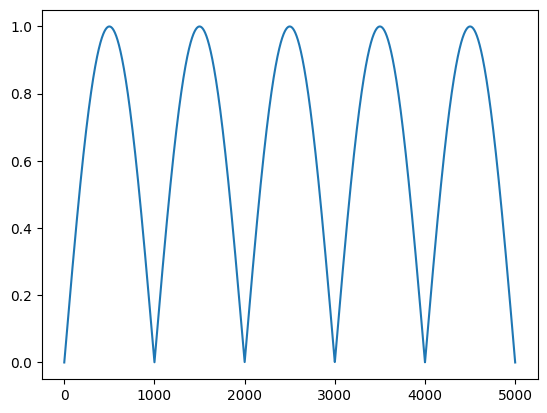

In [48]:
plt.plot(scaled_matrices[:, 1,3])

In [49]:
# Create a toy topology, all link capacities have a value of 5
G = fully_connected_network(num_nodes=4, capacity=1)

# Get ground truth u values 
mlu_ground_truth = np.zeros((num_matrices, ))

for i in range(num_matrices): 
    D = scaled_matrices[i, :, :]
    np.fill_diagonal(D, 0)
    mlu_ground_truth[i] = MinMaxLinkUtil(G, D)

    
# Split ground truth u values into training and testing labels
_, mlu_test_labels = train_test_split(mlu_ground_truth.reshape(-1, 1), 0.8)

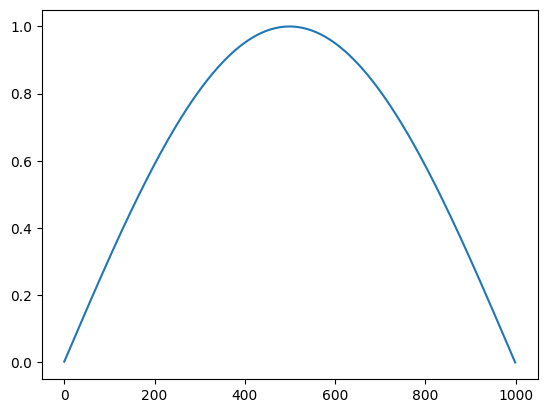

In [50]:
plt.plot(mlu_test_labels)

Train a predictor on the synthetic dataset to directly learn TMs. Use MSE as the loss function. 

In [51]:
# Train-Test Split 
train_data, test_data = train_test_split(scaled_matrices.reshape(-1, 16), 0.8)

# Window the dataset
trainX, trainY = create_dataset(train_data, 10)
testX, testY = create_dataset(test_data, 10)

In [52]:
# Specify model parameters 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
output_size = 16  # Number of output classes 
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [53]:
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(trainX),
                                                 torch.Tensor(trainY), 
                                                )


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

test_dataset  = torch.utils.data.TensorDataset(torch.FloatTensor(testX),
                                                 torch.Tensor(testY),
                                                )


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

In [54]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])  # return the last value
        out = self.sigmoid(out)
        return out

In [55]:
import time

# Define training function

def train(model, train_loader, epochs, criterion, optimizer):
    ''' Train ML Model''' 

    print_interval = 5
    track_losses = np.zeros(epochs)
    start = time.time()

    for epoch in range(epochs): 
        for inputs, targets in train_loader: 
            
            # Pass data to LSTM
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)

            # Compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        training_loss = loss.item()
        track_losses[epoch] = training_loss 

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():10.4e}')

    return track_losses

In [56]:
# Create Model 
model = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

In [57]:
# Train the model
loss = train(model, train_loader, epochs, criterion, optimizer)

Epoch [10/100], Loss: 9.7691e-04
Epoch [20/100], Loss: 3.0558e-04
Epoch [30/100], Loss: 4.2684e-04
Epoch [40/100], Loss: 8.7317e-04
Epoch [50/100], Loss: 2.0622e-04
Epoch [60/100], Loss: 7.5872e-04
Epoch [70/100], Loss: 3.3643e-04
Epoch [80/100], Loss: 2.1166e-04
Epoch [90/100], Loss: 7.0242e-04
Epoch [100/100], Loss: 3.2769e-04


Text(0.5, 1.0, 'Training Loss vs. Epochs')

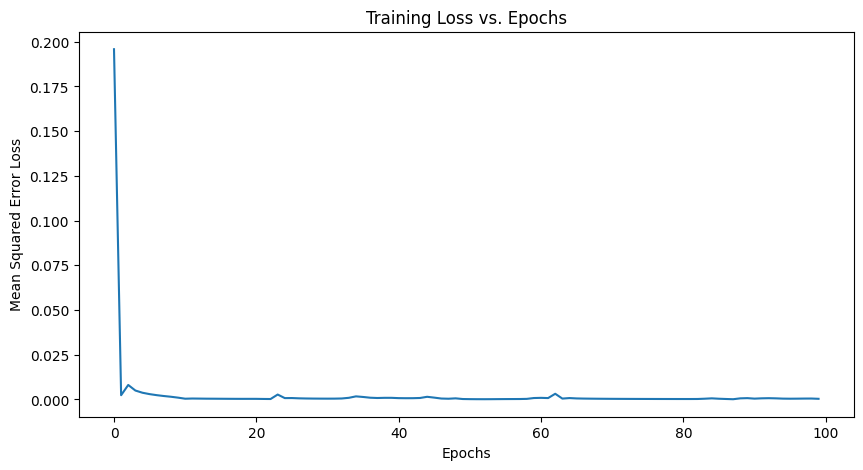

In [58]:
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), loss)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')
ax.set_title('Training Loss vs. Epochs')

In [59]:
# Define testing function
def test(model, criterion, test_loader, testY): 
    
    ''' Test ML Model '''
    
    model.eval() # Put model in eval mode 
    total_loss = 0.0 
    num_samples = 0 

    model_outputs = np.zeros((testY.shape[0], testY.shape[1]))
    test_loss = np.zeros((testY.shape[0], 1))

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_loader): 
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            model_outputs[idx, :] = outputs # Store outputs
            
    average_loss = total_loss / len(test_loader)
    print(f'Average (Normalized) Test Loss: {average_loss:10.4e}')

    return model_outputs, test_loss

In [60]:
model_outputs, test_loss = test(model, criterion, test_loader, testY)

Average (Normalized) Test Loss: 4.3438e-04


Text(440, 50, 'NMSE: 0.013')

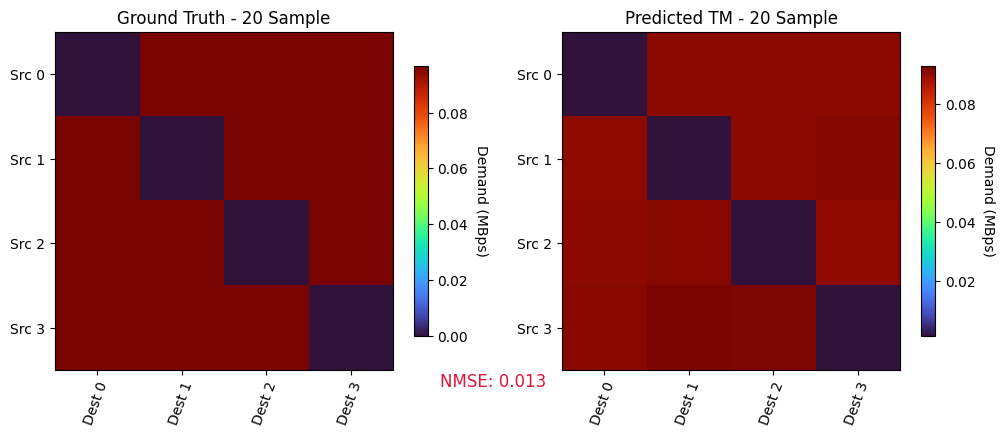

In [61]:
# Visual comparison of model outputs and ground truth
sources = ['Src {}'.format(i) for i in range(0,4)]
destinations = ['Dest {}'.format(i) for i in range(0,4)]

sample_number = 20

# Create a heatmap
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,5))
im1 = ax1.imshow(np.reshape(test_data[sample_number+10, :], (4,4)), cmap = 'turbo') #scaled ground truth

# Create colorbar
cbar = ax1.figure.colorbar(im1, ax=ax1, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(destinations)), labels=destinations)
ax1.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax1.set_title("Ground Truth - %d Sample" % sample_number)

im2 = ax2.imshow(np.reshape(model_outputs[sample_number, :], (4,4)), cmap = 'turbo') #scaled prediction

# Create colorbar
cbar = ax2.figure.colorbar(im2, ax=ax2, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(destinations)), labels=destinations)
ax2.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax2.set_title("Predicted TM - %d Sample" % sample_number)

# Compute normalized mean squared error 
actual = test_data[sample_number+10, :]
predicted = model_outputs[sample_number, :]

mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
mean_actual = sum(actual) / len(actual)
normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
nmse = mse / normalization_factor

plt.annotate('NMSE: %0.3f' % nmse, 
            xy = (440, 50), xycoords='figure pixels', color = 'crimson',
            fontsize = 12)

In [62]:
# Compute the MLU on the predictions 
G = fully_connected_network(num_nodes=4, capacity=1)
mlu_preds = np.empty((len(model_outputs), 1))
for i in range(len(model_outputs)):

    D = model_outputs[i, :].reshape(4,4)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D)
    mlu_preds[i] = u

1059.650728232746


/tmp/ipykernel_613292/4273689891.py:1: RuntimeWarning: divide by zero encountered in divide
  bias = mlu_preds/mlu_test_labels[10:]


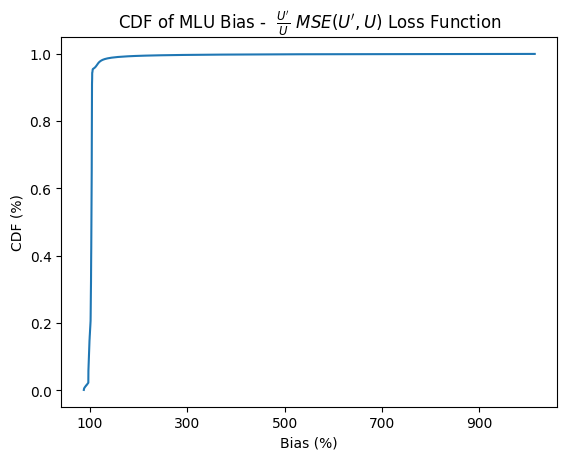

In [63]:
bias = mlu_preds/mlu_test_labels[10:]
data_size = len(bias)

data = np.reshape(bias*100, (len(mlu_preds),))

data_set = sorted(set(data))
bins = np.append(data_set, data_set[-1] + 1)

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=bins, density=False)
counts = counts.astype(float) / data_size

# Find the cdf
cdf = np.cumsum(counts*100)
plt.plot(bin_edges[0:-1], cdf/np.max(cdf))
plt.xlabel('Bias (%)')
plt.ylabel('CDF (%)')
plt.title(r'CDF of MLU Bias -  $\frac{U^{\prime}}{U}$ $MSE(U^{\prime}, U)$ Loss Function')

start, end = plt.xlim()
print(end)
_ = plt.xticks(np.arange(100, end, 200))

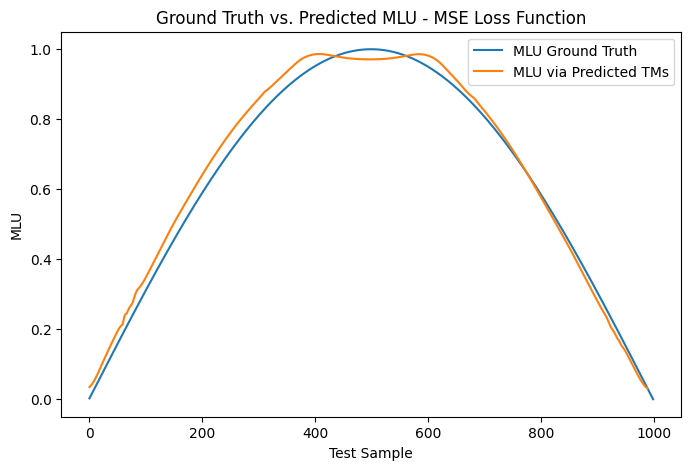

In [68]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mlu_test_labels, label = 'MLU Ground Truth')
ax.plot(mlu_preds, label = 'MLU via Predicted TMs')

ax.set_xlabel('Test Sample')
ax.set_ylabel('MLU')
ax.legend()
_ = ax.set_title('Ground Truth vs. Predicted MLU - MSE Loss Function')

## 9x9 Network

In [4]:
import numpy as np

# Parameters
num_matrices = 1000
matrix_size = (9, 9)

# Generate matrices filled with ones
matrices = np.ones((num_matrices, *matrix_size))

# Create a sine wave function for scaling
# Let's scale the matrices by the sine of indices (0, 1, ..., num_matrices-1)
scaling_factors = np.abs(np.sin(np.linspace(0, 5 * np.pi, num_matrices)))

# Scale each matrix by its corresponding sine value
scaled_matrices = matrices * scaling_factors[:, np.newaxis, np.newaxis]

[np.fill_diagonal(scaled_matrices[i, :, :], 0) for i in range(num_matrices)]

# Check the shape of the resulting array
print(scaled_matrices.shape)  # Should be (5000, 4, 4)

(1000, 9, 9)


In [5]:
# Create a toy topology, all link capacities have a value of 5
G = fully_connected_network(num_nodes=9, capacity=1)

# Get ground truth u values 
mlu_ground_truth = np.zeros((num_matrices, ))

for i in range(num_matrices): 
    D = scaled_matrices[i, :, :]
    np.fill_diagonal(D, 0)
    mlu_ground_truth[i] = MinMaxLinkUtil(G, D)

    
# Split ground truth u values into training and testing labels
_, mlu_test_labels = train_test_split(mlu_ground_truth.reshape(-1, 1), 0.8)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10


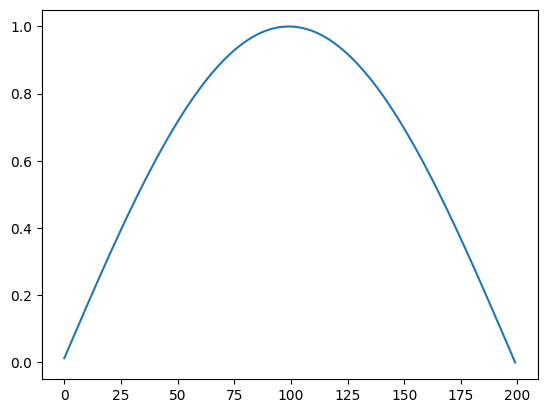

In [6]:
plt.plot(mlu_test_labels)

Train a predictor on the synthetic dataset to directly learn TMs. Use MSE as the loss function. 

In [8]:
# Train-Test Split 
train_data, test_data = train_test_split(scaled_matrices.reshape(-1, 81), 0.8)

# Window the dataset
trainX, trainY = create_dataset(train_data, 10)
testX, testY = create_dataset(test_data, 10)

In [13]:
# Specify model parameters 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
output_size = 81  # Number of output classes 
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 16
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [10]:
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(trainX),
                                                 torch.Tensor(trainY), 
                                                )


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

test_dataset  = torch.utils.data.TensorDataset(torch.FloatTensor(testX),
                                                 torch.Tensor(testY),
                                                )


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])  # return the last value
        out = self.sigmoid(out)
        return out

In [12]:
import time

# Define training function

def train(model, train_loader, epochs, criterion, optimizer):
    ''' Train ML Model''' 

    print_interval = 5
    track_losses = np.zeros(epochs)
    start = time.time()

    for epoch in range(epochs): 
        for inputs, targets in train_loader: 
            
            # Pass data to LSTM
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)

            # Compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        training_loss = loss.item()
        track_losses[epoch] = training_loss 

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():10.4e}')

    return track_losses

In [14]:
# Create Model 
model = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

In [15]:
# Train the model
loss = train(model, train_loader, epochs, criterion, optimizer)

Epoch [10/100], Loss: 9.7500e-04
Epoch [20/100], Loss: 1.2733e-03
Epoch [30/100], Loss: 1.4216e-03
Epoch [40/100], Loss: 8.1352e-04
Epoch [50/100], Loss: 1.1088e-04
Epoch [60/100], Loss: 1.3291e-04
Epoch [70/100], Loss: 6.9307e-05
Epoch [80/100], Loss: 1.3374e-04
Epoch [90/100], Loss: 6.1089e-05
Epoch [100/100], Loss: 8.5280e-05


Text(0.5, 1.0, 'Training Loss vs. Epochs')

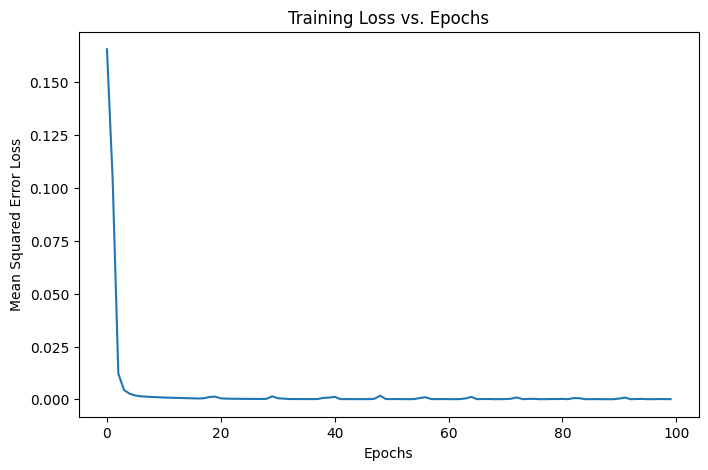

In [16]:
# Plot training loss 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(range(epochs), loss)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')
ax.set_title('Training Loss vs. Epochs')

In [17]:
# Define testing function
def test(model, criterion, test_loader, testY): 
    
    ''' Test ML Model '''
    
    model.eval() # Put model in eval mode 
    total_loss = 0.0 
    num_samples = 0 

    model_outputs = np.zeros((testY.shape[0], testY.shape[1]))
    test_loss = np.zeros((testY.shape[0], 1))

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_loader): 
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            model_outputs[idx, :] = outputs # Store outputs
            
    average_loss = total_loss / len(test_loader)
    print(f'Average (Normalized) Test Loss: {average_loss:10.4e}')

    return model_outputs, test_loss

In [18]:
model_outputs, test_loss = test(model, criterion, test_loader, testY)

C:\Users\marth\AppData\Local\Temp\ipykernel_10748\2811110613.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  model_outputs[idx, :] = outputs # Store outputs


Average (Normalized) Test Loss: 1.2395e-04


Text(440, 50, 'NMSE: 0.001')

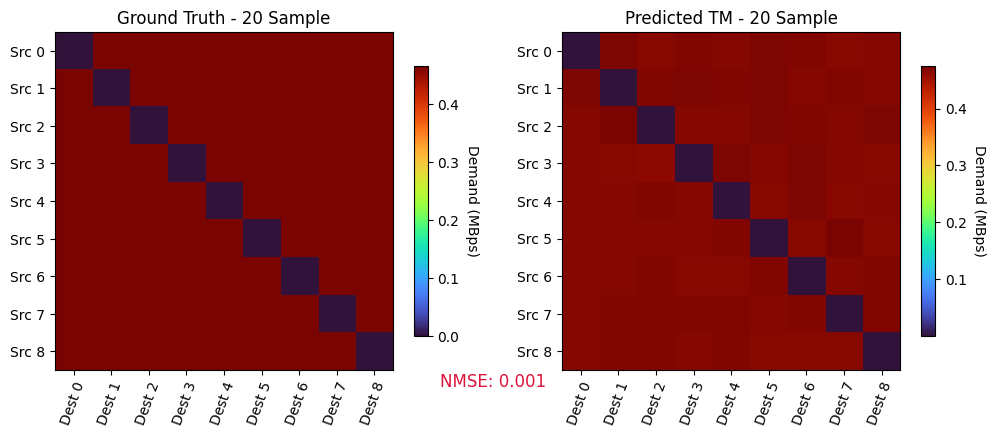

In [20]:
# Visual comparison of model outputs and ground truth
sources = ['Src {}'.format(i) for i in range(0,9)]
destinations = ['Dest {}'.format(i) for i in range(0,9)]

sample_number = 20

# Create a heatmap
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,5))
im1 = ax1.imshow(np.reshape(test_data[sample_number+10, :], (9,9)), cmap = 'turbo') #scaled ground truth

# Create colorbar
cbar = ax1.figure.colorbar(im1, ax=ax1, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(destinations)), labels=destinations)
ax1.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax1.set_title("Ground Truth - %d Sample" % sample_number)

im2 = ax2.imshow(np.reshape(model_outputs[sample_number, :], (9,9)), cmap = 'turbo') #scaled prediction

# Create colorbar
cbar = ax2.figure.colorbar(im2, ax=ax2, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(destinations)), labels=destinations)
ax2.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax2.set_title("Predicted TM - %d Sample" % sample_number)

# Compute normalized mean squared error 
actual = test_data[sample_number+10, :]
predicted = model_outputs[sample_number, :]

mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
mean_actual = sum(actual) / len(actual)
normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
nmse = mse / normalization_factor

plt.annotate('NMSE: %0.3f' % nmse, 
            xy = (440, 50), xycoords='figure pixels', color = 'crimson',
            fontsize = 12)

In [22]:
# Compute the MLU on the predictions 
G = fully_connected_network(num_nodes=9, capacity=1)
mlu_preds = np.empty((len(model_outputs), 1))
for i in range(len(model_outputs)):

    D = model_outputs[i, :].reshape(9,9)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D)
    mlu_preds[i] = u

C:\Users\marth\AppData\Local\Temp\ipykernel_10748\1188027279.py:1: RuntimeWarning: divide by zero encountered in divide
  bias = mlu_preds/mlu_test_labels[10:]


217.6070402802138


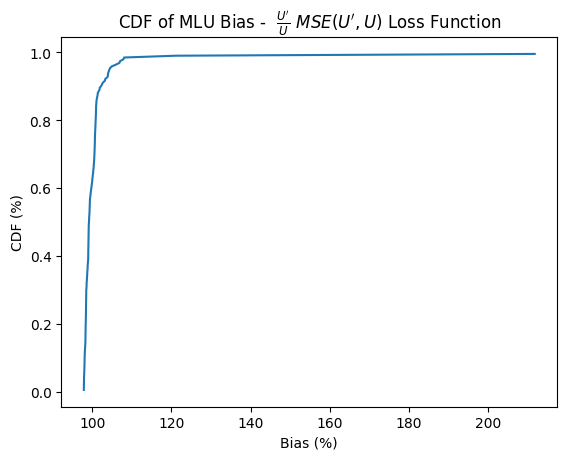

In [23]:
bias = mlu_preds/mlu_test_labels[10:]
data_size = len(bias)

data = np.reshape(bias*100, (len(mlu_preds),))

data_set = sorted(set(data))
bins = np.append(data_set, data_set[-1] + 1)

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=bins, density=False)
counts = counts.astype(float) / data_size

# Find the cdf
cdf = np.cumsum(counts*100)
plt.plot(bin_edges[0:-1], cdf/np.max(cdf))
plt.xlabel('Bias (%)')
plt.ylabel('CDF (%)')
plt.title(r'CDF of MLU Bias -  $\frac{U^{\prime}}{U}$ $MSE(U^{\prime}, U)$ Loss Function')

start, end = plt.xlim()
print(end)
#_ = plt.xticks(np.arange(100, end, 200))

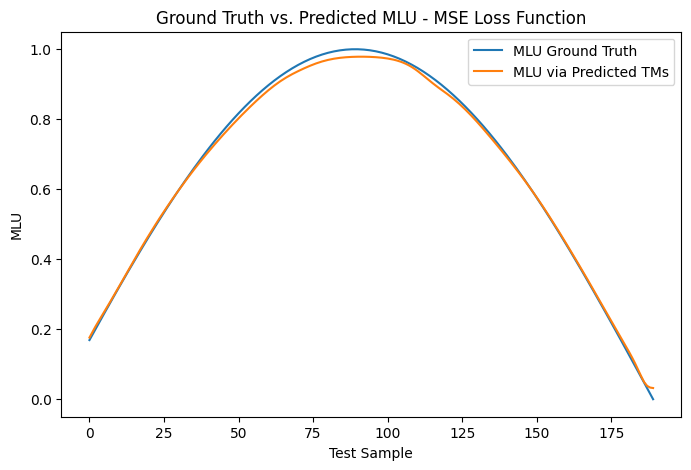

In [25]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mlu_test_labels[10:], label = 'MLU Ground Truth')
ax.plot(mlu_preds, label = 'MLU via Predicted TMs')

ax.set_xlabel('Test Sample')
ax.set_ylabel('MLU')
ax.legend()
_ = ax.set_title('Ground Truth vs. Predicted MLU - MSE Loss Function')

## 12x12 Network